In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade

In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from IPython.display import clear_output
from typing import NamedTuple
from datetime import timedelta, datetime
import yfinance as yf

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt


class SinglePeriod:
    def __init__(
        self,
        data,
        preds,
        budget,
        init_budget,
        sampler_args,
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):

        self.df = data
        self.preds = preds
        self.budget = budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.init_budget = budget

        #print('self.df.columns')
        #print(self.df.columns)
        self.stocks = self.df.columns.tolist()
        self.init_holdings = init_holdings
        #print(f'self.init_holdings in single period: {init_holdings}')

        self.pct_returns = self.df.pct_change()

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")
        #print(f'self.alpha: {self.alpha}')

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}

        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.solution = {}
        self.precision = 2


    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        self.max_num_shares = (self.budget/self.df.loc[idx,:]).astype(int)

        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}

        print(f'idx in single period: {idx}')
        self.price = self.df.loc[idx, :]
        print('price')
        display(self.price)
        self.daily_returns = self.pct_returns.loc[:idx, :]
        print('daily returns')
        display(self.daily_returns)
        self.avg_daily_returns = self.preds.pct_change().loc[idx, :]
        print('avg daily returns')
        display(self.avg_daily_returns)
        self.covariance_matrix = self.daily_returns.cov()

        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]

        print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]

        print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            print(f'init holdings total value: {sum([self.price[s]*self.init_holdings[s] for s in self.stocks])}')
            #self.budget = sum([self.price[s]*self.init_holdings[s] for s in self.stocks])
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0
            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')

            print(f'budget in cqm: {self.budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')


        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            #print('cqm debugging')
            # print(f'risk: {type(risk)}')
            # print(f'returns: {type(returns)}')
            #print(returns)

            cqm.set_objective(self.alpha * risk - returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm
        return self.model



    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.model = self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        variance = 0.0
        for s1, s2 in product(solution, solution):
            #print(f'stock: {stock}, price1: {self.price[s1]}, price2: {self.price[s2]}, covariance_matrix: {self.covariance_matrix[s1][s2]}')
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        #tmp_daily_retuns = self.avg_daily_returns.loc[idx, :]
        for stock in solution:
            #print(f'stock: {stock}, price: {self.price[stock]}, avg_daily_returns: {self.avg_daily_returns[stock]}')
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]
            #est_return += solution[stock]*self.price[stock]*self.tmp_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self,
                data,
                forecast,
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):

        self.save_path = save_path
        self.df = data
        self.preds = forecast
        print('self.preds')
        display(self.preds)
        self.stocks = self.df.columns.values.tolist()

        self.sampler_args = sampler_args
        self.budget = budget
        self.init_budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type

        initial_gspc = self.baseline.query('ds==@dates[0]').values.tolist()[0][0]
        # print('initial baseline')
        # display(self.baseline)
        # print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        # print('final baseline')
        # display(self.baseline)
        # print('initial data')
        # display(self.df.head())

        self.init_holdings = init_holdings
        # if init_holdings is not None:
        #     self.init_holdings = init_holdings
        # else:
        #     self.init_holdings = {s:0 for s in self.stocks}

        # print('iniital_holdings')
        # print(self.init_holdings)

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        # print('init holdings keys')
        # print(set(self.init_holdings.keys()))
        #self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = self.df.columns.values.tolist()
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)
        self.sample_set = {}
        self.sampler_args = sampler_args
        self.solution = {}

    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """

        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []

        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'est_returns', 'value'])


        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')

            previous_idx = idx - timedelta(days=1)
            self.price = self.df.loc[idx, :]
            print('price')
            display(self.price)
            baseline_current = self.baseline.loc[idx, :]

            if first_purchase:
                self.budget = self.init_budget
                #self.agg_results = pd.DataFrame([{'idx': idx, 'variance': 0.0, 'est_returns': 0.0, 'value': sum([self.price[s]*self.init_holdings[s] for s in self.stocks])}])

                print('preds')
                display(self.preds.loc[idx, :])
                print(f'budget in Multiperiod: {self.budget}')

                first_purchase = False
            else:
                self.budget = sum([self.price[s] * self.init_holdings[s] for s in self.stocks])
                print(f'budget in Multiperiod: {self.budget}')

            single_period = SinglePeriod(data=self.df.loc[:idx, :],
                                            preds=self.preds,
                                            budget=self.budget,
                                            init_budget = self.init_budget,
                                            sampler_args=self.sampler_args,
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            baseline_shares = (self.budget / baseline_current)
            #display(self.baseline)
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            returns = self.solution['return']
            variance = self.solution['risk']
            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'est_returns': returns, 'value': value}])])

            #initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / self.budget - 1
            display(self.agg_results)

            # fig = plt.figure(figsize=(10.708,8.2))
            # sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            # sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            # plt.show()
            # print(f'\nRun completed.\n')

        return self.agg_results

In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)

    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)

    # Read in baseline data; resample to monthly
    index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    df_baseline = pd.DataFrame(index=index_df.index, columns=baseline)
    for i in baseline:
        df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [7]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:
                if b == '0':
                    inverse_s += '1'
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)

            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            print(total)
            if total <= budget and total > 0.6 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(score_report)
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0
    # enumerate generations
    for gen in range(n_iter):
        print(gen)
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]

        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
            ax[0].hist(scores)
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [8]:
initial_date = '2021-01-01'
end_date = '2021-07-01'
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
ticker_list = first_table['Symbol'].values.tolist()
source = yf.download(ticker_list, start=initial_date, end=end_date)[['Close']]
df_src = source.copy()
df_src.columns = df_src.columns.droplevel(0)
df_src.dropna(axis=1, inplace=True)
stock_list = df_src.columns.values.tolist()
df_src.reset_index(inplace=True)
df_src.rename(columns={'Date':'ds'}, inplace=True)
df_src.set_index('ds', inplace=True)
df_src.head()

[*********************100%%**********************]  503 of 503 completed

ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-01 -> 2021-07-01)')
ERROR:yfinance:['CEG', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1609477200, endDate = 1625112000")
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-04,118.639999,15.13,157.339996,129.410004,105.410004,96.500000,109.110001,34.900002,256.459991,485.339996,...,106.900002,65.660004,41.500000,53.750000,99.690002,105.820000,148.699036,378.130005,42.930000,163.589996
2021-01-05,119.610001,15.43,157.169998,131.009995,106.500000,97.760002,110.459999,35.040001,257.920013,485.690002,...,110.190002,65.019997,43.500000,55.290001,99.570000,105.830002,151.271851,380.570007,43.610001,164.729996
2021-01-06,122.889999,15.52,166.250000,126.599998,105.580002,106.169998,110.230003,36.580002,260.739990,466.309998,...,110.849998,66.459999,44.610001,57.959999,103.769997,106.410004,155.582520,394.820007,48.509998,167.149994
2021-01-07,126.160004,15.38,167.669998,130.919998,106.709999,110.129997,111.300003,36.240002,263.200012,477.739990,...,109.750000,65.160004,44.959999,57.660000,108.480003,105.599998,154.660187,409.100006,49.990002,167.000000
2021-01-08,127.059998,15.13,170.059998,132.050003,107.269997,110.029999,111.610001,36.439999,264.160004,485.100006,...,109.029999,65.760002,45.459999,58.180000,107.379997,107.150002,154.320389,405.470001,48.720001,168.110001


In [9]:
initial_date = '2021-01-01'
end_date = '2021-07-01'
source = yf.download(['^GSPC'], start=initial_date, end=end_date)[['Close']]
df_baseline = source.copy()
display(df_baseline.head())
df_baseline = source[['Close']]
df_baseline.dropna(axis=1, inplace=True)
df_baseline.reset_index(inplace=True)
df_baseline.rename(columns={'Date':'ds'}, inplace=True)
df_baseline.set_index('ds', inplace=True)
df_baseline.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


,Close
ds,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


In [10]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.01,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.0,
            'n_iter': 100,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'Experiment 2',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}

df_forecast_init = pd.read_pickle('/content/drive/MyDrive/models/lgbm_20_backtest.pkl')
df_forecast_init.index.names = ['ds']
print('df_forecast_init')
display(df_forecast_init.tail())
n_stocks = 4
stocks = df_forecast_init.columns.values.tolist()[:n_stocks]

# print('df')
# display(df.loc[:, stocks].shift(1).head())
# display(df.loc[:, stocks].shift(1).tail())
df = df_src.loc[:, stocks].shift(1)
df.dropna(inplace=True)
display(df.head())


#df_forecast = df_src.loc[:, stocks].copy()
df_forecast = pd.concat([df.loc[:(datetime.strptime(cfg['dates'][0], '%Y-%m-%d') - timedelta(days=1)), :], df_forecast_init.loc[:, stocks]], axis=0)


df_forecast_init


component,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ
ds,,,,,,,,,,,,,,,,,,,,
2021-06-24,144.533275,22.311011,200.618412,134.000369,114.444677,117.137398,110.770653,38.518082,286.168220,557.019597,163.760820,61.415389,195.987823,283.222162,82.608674,83.349458,25.624797,52.799280,47.613560,154.537456
2021-06-25,145.644250,22.329560,200.331560,133.175076,114.856547,116.654139,111.652757,38.897167,288.404758,558.395945,165.247477,61.819882,196.153547,287.207009,81.194616,83.090155,25.801721,52.910658,47.802288,155.703599
2021-06-28,144.867553,22.435920,202.416632,133.355656,113.439567,116.168338,112.102045,39.150949,291.016352,558.459812,166.915255,61.930524,196.802058,288.886774,81.919258,84.270725,26.230586,54.662100,49.180730,157.439943
2021-06-29,145.405624,21.009751,204.094801,134.260115,112.648726,114.900173,113.982671,38.643299,291.487102,570.658734,166.156724,61.283882,195.745522,295.854965,81.933233,85.141641,26.788827,53.393008,47.777303,156.951892
2021-06-30,146.019711,21.378169,204.518649,134.139080,112.492505,115.130130,114.293718,39.001348,291.728585,571.483641,168.679069,61.458320,195.428718,295.781137,80.670301,83.853520,26.031758,53.714718,47.578363,156.551092


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,118.639999,15.13,157.339996,129.410004
2021-01-06,119.610001,15.43,157.169998,131.009995
2021-01-07,122.889999,15.52,166.250000,126.599998
2021-01-08,126.160004,15.38,167.669998,130.919998
2021-01-11,127.059998,15.13,170.059998,132.050003


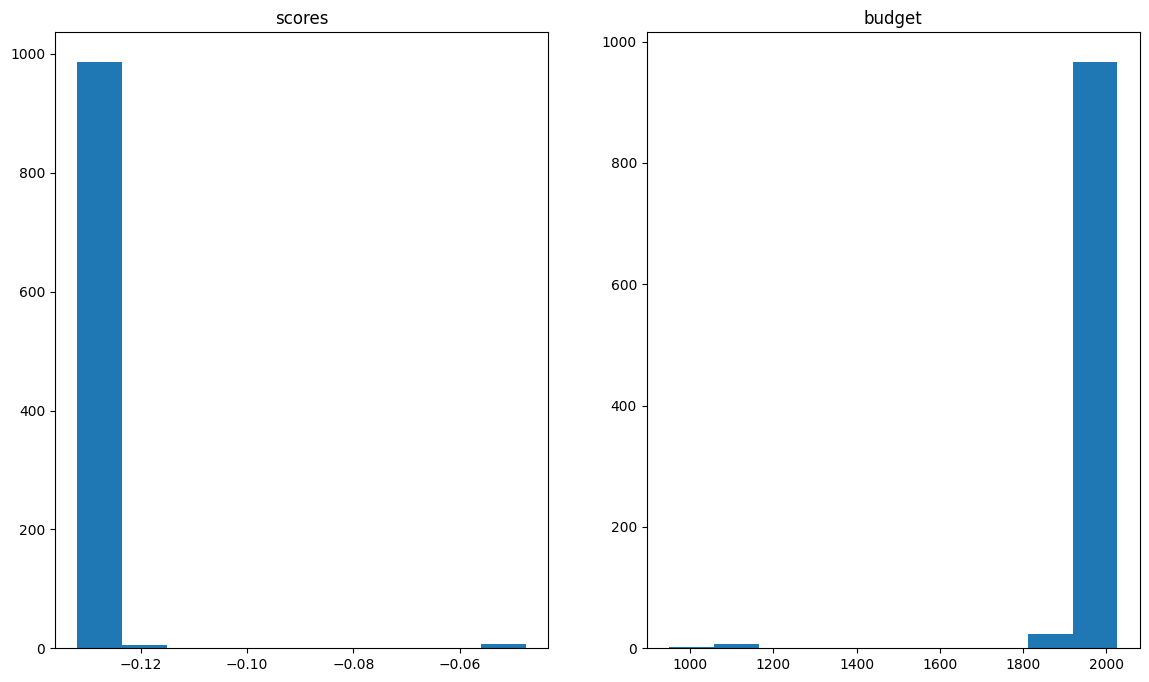

90 best eval:-0.1319549938021196
mean score: -0.1311948193401579
best total: 2012.3300170898438
91
92
93
94
95
96
97
98
99
best: [8 0 1 7]
best_eval: -0.1319549938021196
best_total: 2012.3300170898438
pop: [8, 0, 1, 7]


In [11]:
init_holdings_df, budget = generate_initial_state(df, cfg['n_iter'], cfg['r_cross'], cfg['r_mut'], cfg['n_pop'], cfg['budget'])
init_holdings_df.to_pickle(cfg['save_path']+'init_holdings.pkl')

#init_holdings_df = pd.read_pickle(cfg['save_path']+'init_holdings.pkl')
init_holdings = {}

for idx, row in init_holdings_df.iterrows():
    init_holdings.update({row['a']: row['b']})

prices = df.loc[cfg['dates'][0], :].values.tolist()
pop = init_holdings_df['b'].values.tolist()
print(f'pop: {pop}')
budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])

In [12]:
# fig = plt.figure(figsize=(10.708,8.2))
# sns.scatterplot(x='ds', y=df_forecast_init.sum(axis=1), data=df_forecast_init, label='Forecast')
# sns.scatterplot(x='ds', y=df.sum(axis=1), data=df.loc['2021-06-01':, :], label='Ground Truth')
# # sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
# # sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
# plt.show()

In [13]:
my_portfolio = MultiPeriod(data=df,
                        forecast=df_forecast,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=cfg['sampler_args'],
                        dates=cfg['dates'],
                        file_path=cfg['file_path'],
                        model_type=cfg['model_type'],
                        alpha=cfg['alpha'],
                        verbose=cfg['verbose'],
                        t_cost=cfg['t_cost'],
                        label=cfg['label'],
                        init_holdings=init_holdings,
                        save_path=cfg['save_path']+cfg['label']+'/'
                        )

df_results = my_portfolio.run(min_return=cfg['min_return'], max_risk=cfg['max_risk'], num=cfg['num'])

self.preds


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,118.639999,15.130000,157.339996,129.410004
2021-01-06,119.610001,15.430000,157.169998,131.009995
2021-01-07,122.889999,15.520000,166.250000,126.599998
2021-01-08,126.160004,15.380000,167.669998,130.919998
2021-01-11,127.059998,15.130000,170.059998,132.050003
...,...,...,...,...
2021-06-24,144.533275,22.311011,200.618412,134.000369
2021-06-25,145.644250,22.329560,200.331560,133.175076
2021-06-28,144.867553,22.435920,202.416632,133.355656


num_days: 22
idx: 2021-06-01 00:00:00
price


A       138.130005
AAL      24.240000
AAP     189.729996
AAPL    124.610001
Name: 2021-06-01 00:00:00, dtype: float64

preds


A       135.783294
AAL      24.246519
AAP     191.890420
AAPL    124.884786
Name: 2021-06-01 00:00:00, dtype: float64

budget in Multiperiod: 2167.0400390625
idx in single period: 2021-06-01 00:00:00
price


A       138.130005
AAL      24.240000
AAP     189.729996
AAPL    124.610001
Name: 2021-06-01 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-05-25,0.007861,0.018609,-0.022007,0.013314
2021-05-26,-0.000825,0.009569,-0.013900,-0.001574
2021-05-27,0.000450,0.029729,0.005372,-0.000394


avg daily returns


A      -0.012772
AAL    -0.007511
AAP     0.017231
AAPL   -0.003155
Name: 2021-06-01 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.8219217308581452, ('AAL', 'A'): 0.3004361348299089, ('AAL', 'AAL'): 0.5971390850627484, ('AAP', 'A'): 3.084812756080672, ('AAP', 'AAL'): 0.8922472870678483, ('AAP', 'AAP'): 12.782089303041534, ('AAPL', 'A'): 3.9318521004513696, ('AAPL', 'AAL'): -0.1564171703973175, ('AAPL', 'AAP'): -2.5542724808131565, ('AAPL', 'AAPL'): 5.345321915842802}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -1.764235559404816, 'AAL': -0.18205476539520576, 'AAP': 3.269201764624322, 'AAPL': -0.39309877086873035}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 98
solution_stocks: {'A': 0, 'AAL': 11, 'AAP': 10, 'AAPL': 0}
solution_return: 30.69
solution_risk: 1448.61
spending: 1974.2099590301514
sales: 1977.310043334961
transaction: 0.0

Estimated Returns: 30.69
Sales Revenue:

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.001431


idx: 2021-06-02 00:00:00
price


A       137.199997
AAL      24.670000
AAP     194.649994
AAPL    124.279999
Name: 2021-06-02 00:00:00, dtype: float64

budget in Multiperiod: 2217.869939804077
idx in single period: 2021-06-02 00:00:00
price


A       137.199997
AAL      24.670000
AAP     194.649994
AAPL    124.279999
Name: 2021-06-02 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-05-26,-0.000825,0.009569,-0.013900,-0.001574
2021-05-27,0.000450,0.029729,0.005372,-0.000394
2021-05-28,0.031885,0.022176,-0.001958,-0.012377


avg daily returns


A       0.003534
AAL     0.011313
AAP    -0.006112
AAPL   -0.008487
Name: 2021-06-02 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.7461312294742175, ('AAL', 'A'): 0.29374542603379994, ('AAL', 'AAL'): 0.6133308907988754, ('AAP', 'A'): 3.008005344024307, ('AAP', 'AAL'): 0.9506770565623233, ('AAP', 'AAP'): 13.532589944430853, ('AAPL', 'A'): 3.8632875702193203, ('AAPL', 'AAL'): -0.15904487573611703, ('AAPL', 'AAP'): -2.61540379244957, ('AAPL', 'AAPL'): 5.2653083603576665}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.48487284719633245, 'AAL': 0.2790909214452505, 'AAP': -1.1896456847810237, 'AAPL': -1.054790273013443}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 85
solution_stocks: {'A': 12, 'AAL': 23, 'AAP': 0, 'AAPL': 0}
solution_return: 12.24
solution_risk: 944.97
spending: 1942.4399642944336
sales: 1946.4999389648438
transaction: 0.0

Estimated Returns: 12.24
Sales Revenue:

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.024316
0,2021-06-02,944.97,12.24,2213.809965,-0.001831


idx: 2021-06-03 00:00:00
price


A       136.570007
AAL      25.820000
AAP     191.330002
AAPL    125.059998
Name: 2021-06-03 00:00:00, dtype: float64

budget in Multiperiod: 2232.700080871582
idx in single period: 2021-06-03 00:00:00
price


A       136.570007
AAL      25.820000
AAP     191.330002
AAPL    125.059998
Name: 2021-06-03 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-05-27,0.000450,0.029729,0.005372,-0.000394
2021-05-28,0.031885,0.022176,-0.001958,-0.012377
2021-06-01,0.004290,-0.007777,0.005778,-0.005348


avg daily returns


A      -0.011707
AAL     0.012778
AAP     0.001244
AAPL    0.007863
Name: 2021-06-03 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.682191618844847, ('AAL', 'A'): 0.2857224888633553, ('AAL', 'AAL'): 0.6763082528903048, ('AAP', 'A'): 2.974230770134162, ('AAP', 'AAL'): 0.8918531302668526, ('AAP', 'AAP'): 13.079394308772791, ('AAPL', 'A'): 3.818552397376063, ('AAPL', 'AAL'): -0.14901159723971602, ('AAPL', 'AAP'): -2.6199545508825155, ('AAPL', 'AAPL'): 5.285760056209415}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -1.598761904017601, 'AAL': 0.329917542247089, 'AAP': 0.23809110417744472, 'AAPL': 0.9833897053853428}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 96
solution_stocks: {'A': 0, 'AAL': 23, 'AAP': 2, 'AAPL': 10}
solution_return: 17.9
solution_risk: 893.01
spending: 1633.2599792480469
sales: 1638.840087890625
transaction: 0.0

Estimated Returns: 17.9
Sales Revenue: 1638.8

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.030797
0,2021-06-02,944.97,12.24,2213.809965,-0.008461
0,2021-06-03,893.01,17.90,2227.119972,-0.002499


idx: 2021-06-04 00:00:00
price


A       136.369995
AAL      24.930000
AAP     191.139999
AAPL    123.540001
Name: 2021-06-04 00:00:00, dtype: float64

budget in Multiperiod: 2191.0700149536133
idx in single period: 2021-06-04 00:00:00
price


A       136.369995
AAL      24.930000
AAP     191.139999
AAPL    123.540001
Name: 2021-06-04 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-05-28,0.031885,0.022176,-0.001958,-0.012377
2021-06-01,0.004290,-0.007777,0.005778,-0.005348
2021-06-02,-0.006733,0.017739,0.025932,-0.002648


avg daily returns


A       0.002772
AAL    -0.002359
AAP     0.001175
AAPL   -0.000944
Name: 2021-06-04 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.6373042041895562, ('AAL', 'A'): 0.2804892820155398, ('AAL', 'AAL'): 0.6340084441449609, ('AAP', 'A'): 2.9426303555360684, ('AAP', 'AAL'): 0.86320742530933, ('AAP', 'AAP'): 12.930010253330853, ('AAPL', 'A'): 3.741428150071202, ('AAPL', 'AAL'): -0.1122235759468937, ('AAPL', 'AAP'): -2.543719855008465, ('AAPL', 'AAPL'): 5.129069951447265}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.3780768638646245, 'AAL': -0.05880930321251871, 'AAP': 0.22462215488426754, 'AAPL': -0.1165991313583569}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 97
solution_stocks: {'A': 10, 'AAL': 5, 'AAP': 3, 'AAPL': 1}
solution_return: 4.04
solution_risk: 645.55
spending: 1554.8399505615234
sales: 1560.6000137329102
transaction: 0.0

Estimated Returns: 4.04
Sales Revenue: 1560

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.012382
0,2021-06-02,944.97,12.24,2213.809965,0.010378
0,2021-06-03,893.01,17.90,2227.119972,0.016453
0,2021-06-04,645.55,4.04,2185.309952,-0.002629


idx: 2021-06-07 00:00:00
price


A       137.899994
AAL      24.299999
AAP     192.759995
AAPL    125.889999
Name: 2021-06-07 00:00:00, dtype: float64

budget in Multiperiod: 2204.6699180603027
idx in single period: 2021-06-07 00:00:00
price


A       137.899994
AAL      24.299999
AAP     192.759995
AAPL    125.889999
Name: 2021-06-07 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-01,0.004290,-0.007777,0.005778,-0.005348
2021-06-02,-0.006733,0.017739,0.025932,-0.002648
2021-06-03,-0.004592,0.046615,-0.017056,0.006276


avg daily returns


A       0.012330
AAL    -0.012290
AAP     0.005633
AAPL    0.008408
Name: 2021-06-07 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.700947155218335, ('AAL', 'A'): 0.25471482606233925, ('AAL', 'AAL'): 0.6018372937201335, ('AAP', 'A'): 3.0038443123186553, ('AAP', 'AAL'): 0.8228286324696978, ('AAP', 'AAP'): 13.038288700933837, ('AAPL', 'A'): 3.880740186112491, ('AAPL', 'AAL'): -0.14479322738442651, ('AAPL', 'AAP'): -2.5315982199431453, ('AAPL', 'AAPL'): 5.331080574092813}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.7002808659372133, 'AAL': -0.2986524787377277, 'AAP': 1.085847922343296, 'AAPL': 1.0585119485571763}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 96
solution_stocks: {'A': 13, 'AAL': 1, 'AAP': 2, 'AAPL': 0}
solution_return: 23.98
solution_risk: 761.27
spending: 413.6999816894531
sales: 415.84999084472656
transaction: 0.0

Estimated Returns: 23.98
Sales Revenue: 415

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.018474
0,2021-06-02,944.97,12.24,2213.809965,0.004146
0,2021-06-03,893.01,17.90,2227.119972,0.010183
0,2021-06-04,645.55,4.04,2185.309952,-0.008781
0,2021-06-07,761.27,23.98,2202.519909,-0.000975


idx: 2021-06-08 00:00:00
price


A       137.649994
AAL      24.250000
AAP     193.009995
AAPL    125.900002
Name: 2021-06-08 00:00:00, dtype: float64

budget in Multiperiod: 2199.7199096679688
idx in single period: 2021-06-08 00:00:00
price


A       137.649994
AAL      24.250000
AAP     193.009995
AAPL    125.900002
Name: 2021-06-08 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-02,-0.006733,0.017739,0.025932,-0.002648
2021-06-03,-0.004592,0.046615,-0.017056,0.006276
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154


avg daily returns


A       0.000380
AAL     0.001623
AAP     0.005577
AAPL    0.003174
Name: 2021-06-08 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.654418795133471, ('AAL', 'A'): 0.25280375071626976, ('AAL', 'AAL'): 0.5939328911542284, ('AAP', 'A'): 2.97505579789797, ('AAP', 'AAL'): 0.814877940913606, ('AAP', 'AAP'): 12.947866156272763, ('AAPL', 'A'): 3.8369252035535073, ('AAPL', 'AAL'): -0.1432021300782204, ('AAPL', 'AAP'): -2.5110047457806317, ('AAPL', 'AAPL'): 5.2811520787904}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.052248625981879064, 'AAL': 0.039362096035954364, 'AAP': 1.076479849895052, 'AAPL': 0.3996676537751741}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 93
solution_stocks: {'A': 1, 'AAL': 6, 'AAP': 6, 'AAPL': 6}
solution_return: 9.15
solution_risk: 657.45
spending: 1648.6899871826172
sales: 1651.7999267578125
transaction: 0.0

Estimated Returns: 9.15
Sales Revenue: 1651.80

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.016266
0,2021-06-02,944.97,12.24,2213.809965,0.006405
0,2021-06-03,893.01,17.90,2227.119972,0.012456
0,2021-06-04,645.55,4.04,2185.309952,-0.006551
0,2021-06-07,761.27,23.98,2202.519909,0.001273
0,2021-06-08,657.45,9.15,2196.609970,-0.001414


idx: 2021-06-09 00:00:00
price


A       138.750000
AAL      24.219999
AAP     197.869995
AAPL    126.739998
Name: 2021-06-09 00:00:00, dtype: float64

budget in Multiperiod: 2231.729953765869
idx in single period: 2021-06-09 00:00:00
price


A       138.750000
AAL      24.219999
AAP     197.869995
AAPL    126.739998
Name: 2021-06-09 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-03,-0.004592,0.046615,-0.017056,0.006276
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154
2021-06-07,0.011219,-0.025271,0.008475,0.019022


avg daily returns


A       0.001152
AAL    -0.006148
AAP     0.025949
AAPL    0.002677
Name: 2021-06-09 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.685614981121643, ('AAL', 'A'): 0.24958297846398692, ('AAL', 'AAL'): 0.5870850686263431, ('AAP', 'A'): 3.1222298718115944, ('AAP', 'AAL'): 0.8136936105770312, ('AAP', 'AAP'): 13.674639658044171, ('AAPL', 'A'): 3.871101636034324, ('AAPL', 'AAL'): -0.1450243890266192, ('AAPL', 'AAP'): -2.493761166887192, ('AAPL', 'AAPL'): 5.3082421937701}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.15988713238498653, 'AAL': -0.1488933228617399, 'AAP': 5.134569385313259, 'AAPL': 0.33927545024784317}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 75
solution_stocks: {'A': 0, 'AAL': 5, 'AAP': 10, 'AAPL': 1}
solution_return: 50.94
solution_risk: 1402.47
spending: 791.47998046875
sales: 796.6699886322021
transaction: 0.0

Estimated Returns: 50.94
Sales Revenue: 796.67


,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.030376
0,2021-06-02,944.97,12.24,2213.809965,-0.008030
0,2021-06-03,893.01,17.90,2227.119972,-0.002066
0,2021-06-04,645.55,4.04,2185.309952,-0.020800
0,2021-06-07,761.27,23.98,2202.519909,-0.013089
0,2021-06-08,657.45,9.15,2196.609970,-0.015737
0,2021-06-09,1402.47,50.94,2226.539946,-0.002326


idx: 2021-06-10 00:00:00
price


A       140.130005
AAL      23.850000
AAP     197.029999
AAPL    127.129997
Name: 2021-06-10 00:00:00, dtype: float64

budget in Multiperiod: 2216.6799869537354
idx in single period: 2021-06-10 00:00:00
price


A       140.130005
AAL      23.850000
AAP     197.029999
AAPL    127.129997
Name: 2021-06-10 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154
2021-06-07,0.011219,-0.025271,0.008475,0.019022
2021-06-08,-0.001813,-0.002058,0.001297,0.000079


avg daily returns


A       0.010769
AAL    -0.019609
AAP     0.004347
AAPL    0.010700
Name: 2021-06-10 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.7369482443546627, ('AAL', 'A'): 0.2354243872332346, ('AAL', 'AAL'): 0.5661075619692073, ('AAP', 'A'): 3.082411773399835, ('AAP', 'AAL'): 0.8019252456537828, ('AAP', 'AAP'): 13.447546539989894, ('AAPL', 'A'): 3.8935834724786114, ('AAPL', 'AAL'): -0.145430372138949, ('AAPL', 'AAP'): -2.4769996562095966, ('AAPL', 'AAPL'): 5.292491515970255}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.5090771443167084, 'AAL': -0.4676647318288373, 'AAP': 0.856443645537876, 'AAPL': 1.3602821662442444}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 90
solution_stocks: {'A': 14, 'AAL': 0, 'AAP': 0, 'AAPL': 2}
solution_return: 23.85
solution_risk: 862.63
spending: 2088.950065612793
sales: 2089.5499897003174
transaction: 0.0

Estimated Returns: 23.85
Sales Revenue: 2089.

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.023792
0,2021-06-02,944.97,12.24,2213.809965,-0.001295
0,2021-06-03,893.01,17.90,2227.119972,0.004710
0,2021-06-04,645.55,4.04,2185.309952,-0.014152
0,2021-06-07,761.27,23.98,2202.519909,-0.006388
0,2021-06-08,657.45,9.15,2196.609970,-0.009054
0,2021-06-09,1402.47,50.94,2226.539946,0.004448
0,2021-06-10,862.63,23.85,2216.080063,-0.000271


idx: 2021-06-11 00:00:00
price


A       143.059998
AAL      23.459999
AAP     195.850006
AAPL    126.110001
Name: 2021-06-11 00:00:00, dtype: float64

budget in Multiperiod: 2255.0599670410156
idx in single period: 2021-06-11 00:00:00
price


A       143.059998
AAL      23.459999
AAP     195.850006
AAPL    126.110001
Name: 2021-06-11 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-07,0.011219,-0.025271,0.008475,0.019022
2021-06-08,-0.001813,-0.002058,0.001297,0.000079
2021-06-09,0.007991,-0.001237,0.025180,0.006672


avg daily returns


A      -0.000768
AAL    -0.019220
AAP    -0.023627
AAPL   -0.010167
Name: 2021-06-11 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9285283392862484, ('AAL', 'A'): 0.2092321882318528, ('AAL', 'AAL'): 0.5449126918400486, ('AAP', 'A'): 3.0173580287580903, ('AAP', 'AAL'): 0.7914684242714172, ('AAP', 'AAP'): 13.187855170317793, ('AAPL', 'A'): 3.8554222214021356, ('AAPL', 'AAL'): -0.13142033741313933, ('AAPL', 'AAP'): -2.389823737163668, ('AAPL', 'AAPL'): 5.169071345228281}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -0.1098887252766979, 'AAL': -0.4509069472626638, 'AAP': -4.62729439540959, 'AAPL': -1.282168985817095}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 100
solution_stocks: {'A': 14, 'AAL': 0, 'AAP': 0, 'AAPL': 2}
solution_return: -4.1
solution_risk: 898.62
spending: 0.0
sales: 0.0
transaction: 0.0

Estimated Returns: -4.1
Sales Revenue: 0.00
Purchase Cost: 0.00
Transac

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.040407
0,2021-06-02,944.97,12.24,2213.809965,-0.018292
0,2021-06-03,893.01,17.90,2227.119972,-0.012390
0,2021-06-04,645.55,4.04,2185.309952,-0.030930
0,2021-06-07,761.27,23.98,2202.519909,-0.023299
0,2021-06-08,657.45,9.15,2196.609970,-0.025919
0,2021-06-09,1402.47,50.94,2226.539946,-0.012647
0,2021-06-10,862.63,23.85,2216.080063,-0.017286
0,2021-06-11,898.62,-4.10,2255.059967,0.000000


idx: 2021-06-14 00:00:00
price


A       143.529999
AAL      23.530001
AAP     199.440002
AAPL    127.349998
Name: 2021-06-14 00:00:00, dtype: float64

budget in Multiperiod: 2264.1199798583984
idx in single period: 2021-06-14 00:00:00
price


A       143.529999
AAL      23.530001
AAP     199.440002
AAPL    127.349998
Name: 2021-06-14 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-08,-0.001813,-0.002058,0.001297,0.000079
2021-06-09,0.007991,-0.001237,0.025180,0.006672
2021-06-10,0.009946,-0.015277,-0.004245,0.003077


avg daily returns


A       0.005239
AAL    -0.000330
AAP     0.027183
AAPL    0.012506
Name: 2021-06-14 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.918510626434786, ('AAL', 'A'): 0.20847593295246214, ('AAL', 'AAL'): 0.5431521753005165, ('AAP', 'A'): 3.066847725902212, ('AAP', 'AAL'): 0.7988540848977588, ('AAP', 'AAP'): 13.644602114616825, ('AAPL', 'A'): 3.875131881832222, ('AAPL', 'AAL'): -0.13271435798633424, ('AAPL', 'AAP'): -2.361116776491427, ('AAPL', 'AAPL'): 5.237338564923023}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.7518982186902009, 'AAL': -0.007770700574685243, 'AAP': 5.421323704616946, 'AAPL': 1.592670463715142}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 81
solution_stocks: {'A': 0, 'AAL': 6, 'AAP': 10, 'AAPL': 1}
solution_return: 55.76
solution_risk: 1412.77
spending: 2135.5800285339355
sales: 2136.7699813842773
transaction: 0.0

Estimated Returns: 55.76
Sales Revenue: 21

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.044247
0,2021-06-02,944.97,12.24,2213.809965,-0.022221
0,2021-06-03,893.01,17.90,2227.119972,-0.016342
0,2021-06-04,645.55,4.04,2185.309952,-0.034808
0,2021-06-07,761.27,23.98,2202.519909,-0.027207
0,2021-06-08,657.45,9.15,2196.609970,-0.029817
0,2021-06-09,1402.47,50.94,2226.539946,-0.016598
0,2021-06-10,862.63,23.85,2216.080063,-0.021218
0,2021-06-11,898.62,-4.10,2255.059967,-0.004002
0,2021-06-14,1412.77,55.76,2262.930027,-0.000526


idx: 2021-06-15 00:00:00
price


A       144.389999
AAL      22.990000
AAP     198.589996
AAPL    130.479996
Name: 2021-06-15 00:00:00, dtype: float64

budget in Multiperiod: 2254.3199577331543
idx in single period: 2021-06-15 00:00:00
price


A       144.389999
AAL      22.990000
AAP     198.589996
AAPL    130.479996
Name: 2021-06-15 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-09,0.007991,-0.001237,0.025180,0.006672
2021-06-10,0.009946,-0.015277,-0.004245,0.003077
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023


avg daily returns


A       0.013639
AAL    -0.020751
AAP    -0.002929
AAPL    0.020060
Name: 2021-06-15 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9328155472515967, ('AAL', 'A'): 0.19621142330686964, ('AAL', 'AAL'): 0.5173826586167763, ('AAP', 'A'): 3.0299676791820405, ('AAP', 'AAL'): 0.7850101121827002, ('AAP', 'AAP'): 13.420986623032253, ('AAPL', 'A'): 3.992579363005602, ('AAPL', 'AAL'): -0.16809384930359583, ('AAPL', 'AAP'): -2.4625144330223248, ('AAPL', 'AAPL'): 5.540513086280872}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.9693317584554515, 'AAL': -0.47706866828105277, 'AAP': -0.5816559636543573, 'AAPL': 2.6174356964358845}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 81
solution_stocks: {'A': 7, 'AAL': 3, 'AAP': 0, 'AAPL': 9}
solution_return: 35.91
solution_risk: 897.26
spending: 2054.5699615478516
sales: 2054.8699626922607
transaction: 0.0

Estimated Returns: 35.91
Sales Revenue:

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.040092
0,2021-06-02,944.97,12.24,2213.809965,-0.017970
0,2021-06-03,893.01,17.90,2227.119972,-0.012066
0,2021-06-04,645.55,4.04,2185.309952,-0.030612
0,2021-06-07,761.27,23.98,2202.519909,-0.022978
0,2021-06-08,657.45,9.15,2196.609970,-0.025600
0,2021-06-09,1402.47,50.94,2226.539946,-0.012323
0,2021-06-10,862.63,23.85,2216.080063,-0.016963
0,2021-06-11,898.62,-4.10,2255.059967,0.000328
0,2021-06-14,1412.77,55.76,2262.930027,0.003819


idx: 2021-06-16 00:00:00
price


A       144.619995
AAL      22.790001
AAP     200.660004
AAPL    129.639999
Name: 2021-06-16 00:00:00, dtype: float64

budget in Multiperiod: 2247.4699630737305
idx in single period: 2021-06-16 00:00:00
price


A       144.619995
AAL      22.790001
AAP     200.660004
AAPL    129.639999
Name: 2021-06-16 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-10,0.009946,-0.015277,-0.004245,0.003077
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023
2021-06-14,0.003285,0.002984,0.018330,0.009833


avg daily returns


A       0.008302
AAL    -0.005402
AAP     0.000365
AAPL   -0.014506
Name: 2021-06-16 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.909824590475294, ('AAL', 'A'): 0.19326653005984645, ('AAL', 'AAL'): 0.5046177965268056, ('AAP', 'A'): 3.0376528368442535, ('AAP', 'AAL'): 0.7705820046824537, ('AAP', 'AAP'): 13.602697850824727, ('AAPL', 'A'): 3.9380077997818894, ('AAPL', 'AAL'): -0.15950670542542528, ('AAPL', 'AAP'): -2.475171601074295, ('AAPL', 'AAPL'): 5.426814044217458}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.2006590414092058, 'AAL': -0.12311202819534649, 'AAP': 0.07317146909657456, 'AAPL': -1.8805384348920928}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 84
solution_stocks: {'A': 14, 'AAL': 4, 'AAP': 0, 'AAPL': 1}
solution_return: 14.44
solution_risk: 845.14
spending: 1035.1299667358398
sales: 1037.1199951171875
transaction: 0.0

Estimated Returns: 14.44
Sales Revenue

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.037166
0,2021-06-02,944.97,12.24,2213.809965,-0.014977
0,2021-06-03,893.01,17.90,2227.119972,-0.009055
0,2021-06-04,645.55,4.04,2185.309952,-0.027658
0,2021-06-07,761.27,23.98,2202.519909,-0.020000
0,2021-06-08,657.45,9.15,2196.609970,-0.022630
0,2021-06-09,1402.47,50.94,2226.539946,-0.009313
0,2021-06-10,862.63,23.85,2216.080063,-0.013967
0,2021-06-11,898.62,-4.10,2255.059967,0.003377
0,2021-06-14,1412.77,55.76,2262.930027,0.006879


idx: 2021-06-17 00:00:00
price


A       143.589996
AAL      22.830000
AAP     196.919998
AAPL    130.149994
Name: 2021-06-17 00:00:00, dtype: float64

budget in Multiperiod: 2231.7299423217773
idx in single period: 2021-06-17 00:00:00
price


A       143.589996
AAL      22.830000
AAP     196.919998
AAPL    130.149994
Name: 2021-06-17 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023
2021-06-14,0.003285,0.002984,0.018330,0.009833
2021-06-15,0.005992,-0.022949,-0.004262,0.024578


avg daily returns


A       0.001360
AAL    -0.000499
AAP    -0.011510
AAPL    0.006881
Name: 2021-06-17 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.834645171736621, ('AAL', 'A'): 0.19175314408713623, ('AAL', 'AAL'): 0.5018955364028475, ('AAP', 'A'): 3.027709285984767, ('AAP', 'AAL'): 0.754762248635935, ('AAP', 'AAP'): 13.13443202170093, ('AAPL', 'A'): 3.8791262977336514, ('AAPL', 'AAL'): -0.15945409783340708, ('AAPL', 'AAP'): -2.4525863254149045, ('AAPL', 'AAPL'): 5.422876993399021}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.19522067740448457, 'AAL': -0.011402515086670182, 'AAP': -2.2664877330596265, 'AAPL': 0.8955012956274898}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 95
solution_stocks: {'A': 4, 'AAL': 4, 'AAP': 0, 'AAPL': 12}
solution_return: 11.48
solution_risk: 1031.89
spending: 1431.6499328613281
sales: 1435.8999633789062
transaction: 0.0

Estimated Returns: 11.48
Sales Revenue

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.030376
0,2021-06-02,944.97,12.24,2213.809965,-0.008030
0,2021-06-03,893.01,17.90,2227.119972,-0.002066
0,2021-06-04,645.55,4.04,2185.309952,-0.020800
0,2021-06-07,761.27,23.98,2202.519909,-0.013089
0,2021-06-08,657.45,9.15,2196.609970,-0.015737
0,2021-06-09,1402.47,50.94,2226.539946,-0.002326
0,2021-06-10,862.63,23.85,2216.080063,-0.007012
0,2021-06-11,898.62,-4.10,2255.059967,0.010454
0,2021-06-14,1412.77,55.76,2262.930027,0.013980


idx: 2021-06-18 00:00:00
price


A       146.919998
AAL      22.230000
AAP     194.389999
AAPL    131.789993
Name: 2021-06-18 00:00:00, dtype: float64

budget in Multiperiod: 2258.0799102783203
idx in single period: 2021-06-18 00:00:00
price


A       146.919998
AAL      22.230000
AAP     194.389999
AAPL    131.789993
Name: 2021-06-18 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-14,0.003285,0.002984,0.018330,0.009833
2021-06-15,0.005992,-0.022949,-0.004262,0.024578
2021-06-16,0.001593,-0.008699,0.010424,-0.006438


avg daily returns


A       0.007402
AAL    -0.043511
AAP    -0.023652
AAPL    0.022854
Name: 2021-06-18 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 4.065818889226831, ('AAL', 'A'): 0.15206370103229616, ('AAL', 'AAL'): 0.47565600187949914, ('AAP', 'A'): 2.870124497154423, ('AAP', 'AAL'): 0.7536409396550713, ('AAP', 'AAP'): 12.760450488859977, ('AAPL', 'A'): 4.073650557646127, ('AAPL', 'AAL'): -0.17519022593929168, ('AAPL', 'AAP'): -2.513450275189113, ('AAPL', 'AAPL'): 5.5345920761875815}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.0874544344499157, 'AAL': -0.9672410114619938, 'AAP': -4.59772558588384, 'AAPL': 3.0119066568881796}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 77
solution_stocks: {'A': 1, 'AAL': 0, 'AAP': 0, 'AAPL': 16}
solution_return: 49.28
solution_risk: 1486.1
spending: 527.1599731445312
sales: 529.6799926757812
transaction: 0.0

Estimated Returns: 49.28
Sales Revenue: 529.

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.041690
0,2021-06-02,944.97,12.24,2213.809965,-0.019605
0,2021-06-03,893.01,17.90,2227.119972,-0.013711
0,2021-06-04,645.55,4.04,2185.309952,-0.032226
0,2021-06-07,761.27,23.98,2202.519909,-0.024605
0,2021-06-08,657.45,9.15,2196.609970,-0.027222
0,2021-06-09,1402.47,50.94,2226.539946,-0.013968
0,2021-06-10,862.63,23.85,2216.080063,-0.018600
0,2021-06-11,898.62,-4.10,2255.059967,-0.001337
0,2021-06-14,1412.77,55.76,2262.930027,0.002148


idx: 2021-06-21 00:00:00
price


A       145.009995
AAL      22.290001
AAP     193.330002
AAPL    130.460007
Name: 2021-06-21 00:00:00, dtype: float64

budget in Multiperiod: 2232.370101928711
idx in single period: 2021-06-21 00:00:00
price


A       145.009995
AAL      22.290001
AAP     193.330002
AAPL    130.460007
Name: 2021-06-21 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-15,0.005992,-0.022949,-0.004262,0.024578
2021-06-16,0.001593,-0.008699,0.010424,-0.006438
2021-06-17,-0.007122,0.001755,-0.018639,0.003934


avg daily returns


A      -0.005132
AAL     0.014775
AAP     0.005424
AAPL   -0.023199
Name: 2021-06-21 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.967030706968286, ('AAL', 'A'): 0.15014129539539373, ('AAL', 'AAL'): 0.47403792795436633, ('AAP', 'A'): 2.8472273630090683, ('AAP', 'AAL'): 0.7456073939379726, ('AAP', 'AAP'): 12.529119416308411, ('AAPL', 'A'): 3.996475072146418, ('AAPL', 'AAL'): -0.17175854520761707, ('AAPL', 'AAP'): -2.418671844503603, ('AAPL', 'AAPL'): 5.391911055496203}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -0.7441834728276123, 'AAL': 0.32934042005931785, 'AAP': 1.0486646154476655, 'AAPL': -3.0265115652739714}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 95
solution_stocks: {'A': 0, 'AAL': 48, 'AAP': 6, 'AAPL': 0}
solution_return: 22.1
solution_risk: 1757.97
spending: 2229.9000549316406
sales: 2232.370101928711
transaction: 0.0

Estimated Returns: 22.1
Sales Revenue: 2

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.030654
0,2021-06-02,944.97,12.24,2213.809965,-0.008314
0,2021-06-03,893.01,17.90,2227.119972,-0.002352
0,2021-06-04,645.55,4.04,2185.309952,-0.021081
0,2021-06-07,761.27,23.98,2202.519909,-0.013372
0,2021-06-08,657.45,9.15,2196.609970,-0.016019
0,2021-06-09,1402.47,50.94,2226.539946,-0.002612
0,2021-06-10,862.63,23.85,2216.080063,-0.007297
0,2021-06-11,898.62,-4.10,2255.059967,0.010164
0,2021-06-14,1412.77,55.76,2262.930027,0.013689


idx: 2021-06-22 00:00:00
price


A       146.410004
AAL      22.450001
AAP     198.470001
AAPL    132.300003
Name: 2021-06-22 00:00:00, dtype: float64

budget in Multiperiod: 2268.4200439453125
idx in single period: 2021-06-22 00:00:00
price


A       146.410004
AAL      22.450001
AAP     198.470001
AAPL    132.300003
Name: 2021-06-22 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-16,0.001593,-0.008699,0.010424,-0.006438
2021-06-17,-0.007122,0.001755,-0.018639,0.003934
2021-06-18,0.023191,-0.026281,-0.012848,0.012601


avg daily returns


A       0.006155
AAL    -0.003267
AAP     0.033152
AAPL    0.023142
Name: 2021-06-22 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 4.020118736243972, ('AAL', 'A'): 0.15282907670339957, ('AAL', 'AAL'): 0.47673466005975546, ('AAP', 'A'): 3.0218973624613437, ('AAP', 'AAL'): 0.7705346670108777, ('AAP', 'AAP'): 13.295329054068663, ('AAPL', 'A'): 4.0926006237368435, ('AAPL', 'AAL'): -0.17153446974527464, ('AAPL', 'AAP'): -2.3413836037505753, ('AAPL', 'AAPL'): 5.525915679192731}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.9011231170612936, 'AAL': -0.0733447126501106, 'AAP': 6.5797432454645035, 'AAPL': 3.0616452412585224}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 83
solution_stocks: {'A': 1, 'AAL': 0, 'AAP': 8, 'AAPL': 4}
solution_return: 65.79
solution_risk: 908.96
spending: 1072.5500183105469
sales: 1077.6000366210938
transaction: 0.0

Estimated Returns: 65.79
Sales Revenue: 

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.046059
0,2021-06-02,944.97,12.24,2213.809965,-0.024074
0,2021-06-03,893.01,17.90,2227.119972,-0.018207
0,2021-06-04,645.55,4.04,2185.309952,-0.036638
0,2021-06-07,761.27,23.98,2202.519909,-0.029051
0,2021-06-08,657.45,9.15,2196.609970,-0.031656
0,2021-06-09,1402.47,50.94,2226.539946,-0.018462
0,2021-06-10,862.63,23.85,2216.080063,-0.023073
0,2021-06-11,898.62,-4.10,2255.059967,-0.005890
0,2021-06-14,1412.77,55.76,2262.930027,-0.002420


idx: 2021-06-23 00:00:00
price


A       146.630005
AAL      22.110001
AAP     200.039993
AAPL    133.979996
Name: 2021-06-23 00:00:00, dtype: float64

budget in Multiperiod: 2282.8699340820312
idx in single period: 2021-06-23 00:00:00
price


A       146.630005
AAL      22.110001
AAP     200.039993
AAPL    133.979996
Name: 2021-06-23 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-17,-0.007122,0.001755,-0.018639,0.003934
2021-06-18,0.023191,-0.026281,-0.012848,0.012601
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092


avg daily returns


A       0.006704
AAL    -0.005276
AAP    -0.003780
AAPL    0.013152
Name: 2021-06-23 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9974791195005053, ('AAL', 'A'): 0.14986814258117104, ('AAL', 'AAL'): 0.4599283503888614, ('AAP', 'A'): 3.022916472512846, ('AAP', 'AAL'): 0.7500237889182825, ('AAP', 'AAP'): 13.401335700742461, ('AAPL', 'A'): 4.113334394984571, ('AAPL', 'AAL'): -0.1814997462212285, ('AAPL', 'AAP'): -2.3367930128494416, ('AAPL', 'AAPL'): 5.6416986781589475}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.9830292137067477, 'AAL': -0.11665514798650652, 'AAP': -0.7560670632398264, 'AAPL': 1.762150983386907}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 84
solution_stocks: {'A': 4, 'AAL': 4, 'AAP': 0, 'AAPL': 12}
solution_return: 24.61
solution_risk: 1074.85
spending: 1600.1699829101562
sales: 1600.3199462890625
transaction: 0.0

Estimated Returns: 24.61
Sales Revenue:

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.052097
0,2021-06-02,944.97,12.24,2213.809965,-0.030251
0,2021-06-03,893.01,17.90,2227.119972,-0.024421
0,2021-06-04,645.55,4.04,2185.309952,-0.042736
0,2021-06-07,761.27,23.98,2202.519909,-0.035197
0,2021-06-08,657.45,9.15,2196.609970,-0.037786
0,2021-06-09,1402.47,50.94,2226.539946,-0.024675
0,2021-06-10,862.63,23.85,2216.080063,-0.029257
0,2021-06-11,898.62,-4.10,2255.059967,-0.012182
0,2021-06-14,1412.77,55.76,2262.930027,-0.008735


idx: 2021-06-24 00:00:00
price


A       147.240005
AAL      22.200001
AAP     200.710007
AAPL    133.699997
Name: 2021-06-24 00:00:00, dtype: float64

budget in Multiperiod: 2282.1599884033203
idx in single period: 2021-06-24 00:00:00
price


A       147.240005
AAL      22.200001
AAP     200.710007
AAPL    133.699997
Name: 2021-06-24 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-18,0.023191,-0.026281,-0.012848,0.012601
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092
2021-06-22,0.009655,0.007178,0.026587,0.014104


avg daily returns


A       0.000755
AAL     0.017086
AAP     0.008024
AAPL   -0.002156
Name: 2021-06-24 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.997291963070957, ('AAL', 'A'): 0.14985810619469192, ('AAL', 'AAL'): 0.45971777741773306, ('AAP', 'A'): 3.020903700844848, ('AAP', 'AAL'): 0.7491720201986787, ('AAP', 'AAP'): 13.376384110521862, ('AAPL', 'A'): 4.084671749059097, ('AAPL', 'AAL'): -0.18034981550445045, ('AAPL', 'AAP'): -2.3210278047355652, ('AAPL', 'AAPL'): 5.571103394390682}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.11117528332467194, 'AAL': 0.37930755788518156, 'AAP': 1.6105258752384515, 'AAPL': -0.2882108730971425}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 89
solution_stocks: {'A': 2, 'AAL': 35, 'AAP': 6, 'AAPL': 0}
solution_return: 23.16
solution_risk: 1264.76
spending: 1892.4600639343262
sales: 1898.8799743652344
transaction: 0.0

Estimated Returns: 23.16
Sales Revenue

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.051802
0,2021-06-02,944.97,12.24,2213.809965,-0.029950
0,2021-06-03,893.01,17.90,2227.119972,-0.024118
0,2021-06-04,645.55,4.04,2185.309952,-0.042438
0,2021-06-07,761.27,23.98,2202.519909,-0.034897
0,2021-06-08,657.45,9.15,2196.609970,-0.037486
0,2021-06-09,1402.47,50.94,2226.539946,-0.024372
0,2021-06-10,862.63,23.85,2216.080063,-0.028955
0,2021-06-11,898.62,-4.10,2255.059967,-0.011875
0,2021-06-14,1412.77,55.76,2262.930027,-0.008426


idx: 2021-06-25 00:00:00
price


A       146.669998
AAL      22.350000
AAP     200.960007
AAPL    133.410004
Name: 2021-06-25 00:00:00, dtype: float64

budget in Multiperiod: 2281.350049972534
idx in single period: 2021-06-25 00:00:00
price


A       146.669998
AAL      22.350000
AAP     200.960007
AAPL    133.410004
Name: 2021-06-25 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092
2021-06-22,0.009655,0.007178,0.026587,0.014104
2021-06-23,0.001503,-0.015145,0.007910,0.012698


avg daily returns


A       0.007687
AAL     0.000831
AAP    -0.001430
AAPL   -0.006159
Name: 2021-06-25 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9388592127284716, ('AAL', 'A'): 0.1480404295933287, ('AAL', 'AAL'): 0.46204136784117744, ('AAP', 'A'): 2.99024928074896, ('AAP', 'AAL'): 0.7485473017271357, ('AAP', 'AAP'): 13.296414606099509, ('AAPL', 'A'): 4.030580839339239, ('AAPL', 'AAL'): -0.18003608220853862, ('AAPL', 'AAP'): -2.29807364491185, ('AAPL', 'AAPL'): 5.50096507716835}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.1273992158322514, 'AAL': 0.0185812663853266, 'AAP': -0.2873407059815368, 'AAPL': -0.8216574916872784}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 83
solution_stocks: {'A': 14, 'AAL': 10, 'AAP': 0, 'AAPL': 0}
solution_return: 15.97
solution_risk: 838.95
spending: 1760.0399780273438
sales: 1764.5100498199463
transaction: 0.0

Estimated Returns: 15.97
Sales Revenue: 176

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.051465
0,2021-06-02,944.97,12.24,2213.809965,-0.029605
0,2021-06-03,893.01,17.90,2227.119972,-0.023771
0,2021-06-04,645.55,4.04,2185.309952,-0.042098
0,2021-06-07,761.27,23.98,2202.519909,-0.034554
0,2021-06-08,657.45,9.15,2196.609970,-0.037145
0,2021-06-09,1402.47,50.94,2226.539946,-0.024025
0,2021-06-10,862.63,23.85,2216.080063,-0.028610
0,2021-06-11,898.62,-4.10,2255.059967,-0.011524
0,2021-06-14,1412.77,55.76,2262.930027,-0.008074


idx: 2021-06-28 00:00:00
price


A       147.279999
AAL      22.219999
AAP     204.429993
AAPL    133.110001
Name: 2021-06-28 00:00:00, dtype: float64

budget in Multiperiod: 2284.119976043701
idx in single period: 2021-06-28 00:00:00
price


A       147.279999
AAL      22.219999
AAP     204.429993
AAPL    133.110001
Name: 2021-06-28 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-22,0.009655,0.007178,0.026587,0.014104
2021-06-23,0.001503,-0.015145,0.007910,0.012698
2021-06-24,0.004160,0.004071,0.003349,-0.002090


avg daily returns


A      -0.005333
AAL     0.004763
AAP     0.010408
AAPL    0.001356
Name: 2021-06-28 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.939258396717282, ('AAL', 'A'): 0.14535936467751898, ('AAL', 'AAL'): 0.453219763529538, ('AAP', 'A'): 3.0461106469811963, ('AAP', 'AAL'): 0.7398007651930811, ('AAP', 'AAP'): 13.72276617634052, ('AAPL', 'A'): 4.0023242441422315, ('AAPL', 'AAL'): -0.17583415656141918, ('AAPL', 'AAP'): -2.331031633427024, ('AAPL', 'AAPL'): 5.43127652261686}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -0.7854200419378039, 'AAL': 0.1058380214483527, 'AAP': 2.127728552849779, 'AAPL': 0.1804918687454706}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 83
solution_stocks: {'A': 0, 'AAL': 5, 'AAP': 8, 'AAPL': 4}
solution_return: 18.27
solution_risk: 927.97
spending: 2167.8799438476562
sales: 2173.0199794769287
transaction: 0.0

Estimated Returns: 18.27
Sales Revenue: 2173.0

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.052615
0,2021-06-02,944.97,12.24,2213.809965,-0.030782
0,2021-06-03,893.01,17.90,2227.119972,-0.024955
0,2021-06-04,645.55,4.04,2185.309952,-0.043260
0,2021-06-07,761.27,23.98,2202.519909,-0.035725
0,2021-06-08,657.45,9.15,2196.609970,-0.038312
0,2021-06-09,1402.47,50.94,2226.539946,-0.025209
0,2021-06-10,862.63,23.85,2216.080063,-0.029788
0,2021-06-11,898.62,-4.10,2255.059967,-0.012723
0,2021-06-14,1412.77,55.76,2262.930027,-0.009277


idx: 2021-06-29 00:00:00
price


A       147.929993
AAL      21.389999
AAP     204.509995
AAPL    134.779999
Name: 2021-06-29 00:00:00, dtype: float64

budget in Multiperiod: 2282.149948120117
idx in single period: 2021-06-29 00:00:00
price


A       147.929993
AAL      21.389999
AAP     204.509995
AAPL    134.779999
Name: 2021-06-29 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-23,0.001503,-0.015145,0.007910,0.012698
2021-06-24,0.004160,0.004071,0.003349,-0.002090
2021-06-25,-0.003871,0.006757,0.001246,-0.002169


avg daily returns


A       0.003714
AAL    -0.063566
AAP     0.008291
AAPL    0.006782
Name: 2021-06-29 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9421360594242345, ('AAL', 'A'): 0.13397190056163658, ('AAL', 'AAL'): 0.4228527341922928, ('AAP', 'A'): 3.0327811965577562, ('AAP', 'AAL'): 0.7123072534996332, ('AAP', 'AAP'): 13.6203849895256, ('AAPL', 'A'): 4.0465983608383, ('AAPL', 'AAL'): -0.19372308577408154, ('AAPL', 'AAP'): -2.3523578399739433, ('AAPL', 'AAPL'): 5.5442055226799765}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.5494461373404728, 'AAL': -1.3596838123607773, 'AAP': 1.695524342548441, 'AAPL': 0.9141190571163322}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 84
solution_stocks: {'A': 3, 'AAL': 0, 'AAP': 7, 'AAPL': 3}
solution_return: 16.26
solution_risk: 803.48
spending: 443.78997802734375
sales: 446.239990234375
transaction: 0.0

Estimated Returns: 16.26
Sales Revenue: 446.24


,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.051798
0,2021-06-02,944.97,12.24,2213.809965,-0.029945
0,2021-06-03,893.01,17.90,2227.119972,-0.024113
0,2021-06-04,645.55,4.04,2185.309952,-0.042434
0,2021-06-07,761.27,23.98,2202.519909,-0.034893
0,2021-06-08,657.45,9.15,2196.609970,-0.037482
0,2021-06-09,1402.47,50.94,2226.539946,-0.024367
0,2021-06-10,862.63,23.85,2216.080063,-0.028951
0,2021-06-11,898.62,-4.10,2255.059967,-0.011870
0,2021-06-14,1412.77,55.76,2262.930027,-0.008422


idx: 2021-06-30 00:00:00
price


A       148.809998
AAL      21.080000
AAP     205.300003
AAPL    136.330002
Name: 2021-06-30 00:00:00, dtype: float64

budget in Multiperiod: 2292.52001953125
idx in single period: 2021-06-30 00:00:00
price


A       148.809998
AAL      21.080000
AAP     205.300003
AAPL    136.330002
Name: 2021-06-30 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-24,0.004160,0.004071,0.003349,-0.002090
2021-06-25,-0.003871,0.006757,0.001246,-0.002169
2021-06-28,0.004159,-0.005817,0.017267,-0.002249


avg daily returns


A       0.004223
AAL     0.017536
AAP     0.002077
AAPL   -0.000901
Name: 2021-06-30 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9591630790812173, ('AAL', 'A'): 0.12802320505064133, ('AAL', 'AAL'): 0.4084462442007407, ('AAP', 'A'): 3.040392317653988, ('AAP', 'AAL'): 0.6969359130373007, ('AAP', 'AAP'): 13.613191910223476, ('AAPL', 'A'): 4.098231460138023, ('AAPL', 'AAL'): -0.20075580794526487, ('AAPL', 'AAP'): -2.3611199982787667, ('AAPL', 'AAPL'): 5.644055289862252}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.6284639313750662, 'AAL': 0.36964985066339456, 'AAP': 0.42635093472563895, 'AAPL': -0.1229008310317877}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 94
solution_stocks: {'A': 9, 'AAL': 45, 'AAP': 0, 'AAPL': 0}
solution_return: 22.29
solution_risk: 1199.65
spending: 1841.459981918335
sales: 1846.0900268554688
transaction: 0.0

Estimated Returns: 22.29
Sales Revenue:

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.056087
0,2021-06-02,944.97,12.24,2213.809965,-0.034333
0,2021-06-03,893.01,17.90,2227.119972,-0.028528
0,2021-06-04,645.55,4.04,2185.309952,-0.046765
0,2021-06-07,761.27,23.98,2202.519909,-0.039258
0,2021-06-08,657.45,9.15,2196.609970,-0.041836
0,2021-06-09,1402.47,50.94,2226.539946,-0.028781
0,2021-06-10,862.63,23.85,2216.080063,-0.033343
0,2021-06-11,898.62,-4.10,2255.059967,-0.016340
0,2021-06-14,1412.77,55.76,2262.930027,-0.012907


In [14]:
#df_results.to_pickle(cfg['save_path']+'results_model_test1.pkl')

In [15]:
df_base = (df.loc['2021-06-01':, :].sum(axis=1) / df.loc['2021-06-01', :].sum()).reset_index()
df_base.head()

,ds,0
0,2021-06-01,1.000000
1,2021-06-02,1.008580
2,2021-06-03,1.004342
3,2021-06-04,0.998469
4,2021-06-07,1.008684


In [16]:
df_results.head()

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,30.69,2163.939955,-0.056087
0,2021-06-02,944.97,12.24,2213.809965,-0.034333
0,2021-06-03,893.01,17.90,2227.119972,-0.028528
0,2021-06-04,645.55,4.04,2185.309952,-0.046765
0,2021-06-07,761.27,23.98,2202.519909,-0.039258


In [17]:
df_results_idx = df_results.set_index('idx')
display(df_results_idx.head())
df_results_norm = (df_results_idx.value / df_results_idx.iloc[0, 2]).to_frame().reset_index()
df_results_norm.head()

,variance,est_returns,value,value_norm
idx,,,,
2021-06-01,1448.61,30.69,2163.939955,-0.056087
2021-06-02,944.97,12.24,2213.809965,-0.034333
2021-06-03,893.01,17.90,2227.119972,-0.028528
2021-06-04,645.55,4.04,2185.309952,-0.046765
2021-06-07,761.27,23.98,2202.519909,-0.039258


,idx,value
0,2021-06-01,1.000000
1,2021-06-02,1.023046
2,2021-06-03,1.029197
3,2021-06-04,1.009876
4,2021-06-07,1.017829


Experiment 1: 4 stocks using ground truth as forecasting

Experiment 2: 4 stocks using lgbm forecasting

In [18]:
df_results_norm.to_pickle(cfg['save_path']+'df_results_norm_experiment2.pkl')

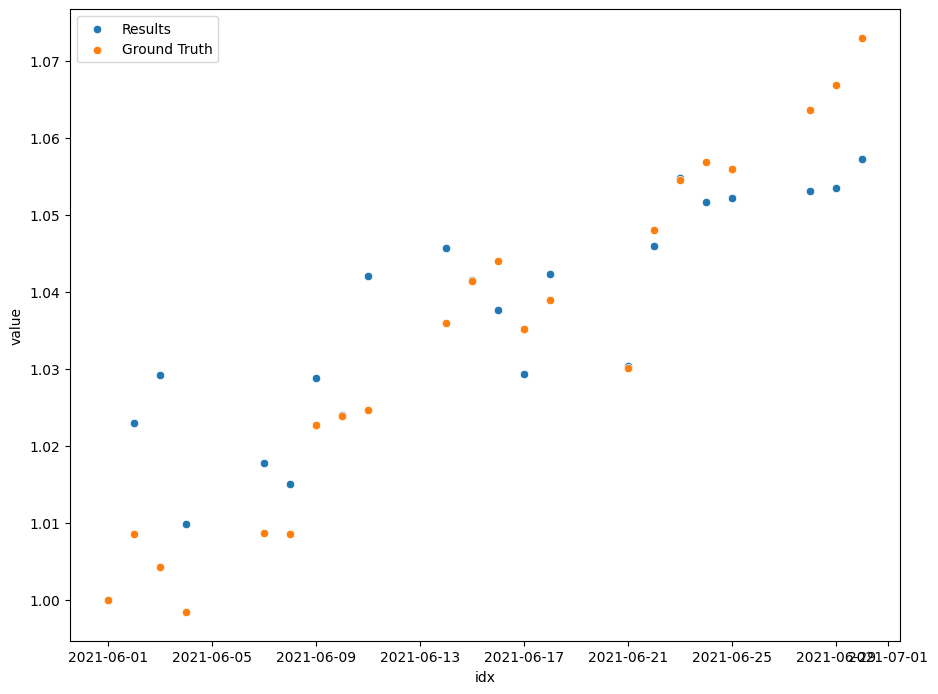

In [19]:
#fig, ax = plt.subplot(1)
fig = plt.figure(figsize=(10.708,8.2))
sns.scatterplot(x=df_results_norm.idx, y=df_results_norm.value, label='Results')
sns.scatterplot(x='ds', y=0, data=df_base, label='Ground Truth')
plt.show()

In [20]:
# self.output.to_pickle(self.save_path+'output.pkl')
# self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
# self.baseline.to_pickle(self.save_path+'baseline.pkl')